In [46]:
import azureml.core
from azureml.core import Experiment, Workspace, Dataset, Datastore, ScriptRunConfig, Run
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies
import os
import shutil
import glob
import math
from os.path import join
import tensorflow as tf
from sys import path
import numpy as np

# check core SDK version number

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.44.0


In [40]:
print(tf.__version__)

2.11.0


In [47]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
# get metadata about the workspace
print(ws.name, ws.location, ws.resource_group, sep='\t')
# list the registered datastores
ws.datastores

landcover-ai	eastus	cic_ai


{'landcoverblobstore': {
   "name": "landcoverblobstore",
   "container_name": "landcover-ai",
   "account_name": "aiprojects",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'acdblobstore': {
   "name": "acdblobstore",
   "container_name": "acd",
   "account_name": "aiprojects",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'solardatablob': {
   "name": "solardatablob",
   "container_name": "solar",
   "account_name": "aiprojects",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'animalopsblobstore2': {
   "name": "animalopsblobstore2",
   "container_name": "animal-ops",
   "account_name": "aiprojects",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'animalopsblobstore': {
   "name": "animalopsblobstore",
   "container_name": "animal-ops",
   "account_name": "aiprojects",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-fi

In [48]:
# access our registered data share containing image data in this workspace
datastore = Datastore.get(workspace = ws, datastore_name = 'solardatablob')

cpk_train_path = (datastore, 'CPK_solar/data/training/')
cpk_eval_path = (datastore, 'CPK_solar/data/eval/')

nc_train_path = (datastore, 'NC_solar/data/training/')
nc_eval_path = (datastore, 'NC_solar/data/eval/')

test_path = (datastore, 'CPK_solar/data/predict/testpred5')

# train_dataset = Dataset.File.from_files(path = [cpk_train_path])
# eval_dataset = Dataset.File.from_files(path = [cpk_eval_path])

# nc_train_dataset = Dataset.File.from_files(path = [nc_train_path])
# nc_eval_dataset = Dataset.File.from_files(path = [nc_eval_path])

# when we combine datasets the selected directories and relative paths to the datastore are brought in
# mount folder
# |-cddatafilestore
# | |-GEE
# | | |-training
# | | |-eval
# | |-Onera
# | | |-training
# | | |-eval

train_dataset = Dataset.File.from_files(path = [cpk_train_path, nc_train_path])
eval_dataset = Dataset.File.from_files(path = [cpk_eval_path, nc_eval_path])
test_dataset = Dataset.File.from_files(path = [test_path])

In [49]:
# define the compute target
ws.compute_targets
mevansGPU = ws.compute_targets['mevansGPU']
aiDSVM = ws.compute_targets['aidsvm']

In [ ]:
# get a previously working environment
exp = Experiment(workspace = ws, name = 'solar-nc-cpk')
run = Run(experiment = exp, run_id = 'solar-nc-cpk_1643057518_98d03e88')
env = run.get_environment()

In [50]:
experiment_name = 'solar-s1s2'
exp = Experiment(workspace = ws, name = 'solar-nc-cpk')

In [27]:
envs = Environment.list(workspace = ws)
env = envs.get('AzureML-tensorflow-2.7-ubuntu20.04-py38-cuda11-gpu')

In [39]:
# add rasterio to our environment
curated_clone = env.clone("customize_curated")
conda_dep = CondaDependencies()
# Installs numpy version 1.17.0 conda package
conda_dep.add_conda_package("rasterio")

# Installs pillow package
# conda_dep.add_pip_package("pillow")

# Adds dependencies to PythonSection of myenv
curated_clone.python.conda_dependencies=conda_dep
curated_clone.register()

In [7]:
# attach our utilities folder to the path to import modules
path.append('/home/azureuser/cloudfiles/code/Users/mevans/Solar_UNet/azure/scv/utils')

In [8]:
# from model_tools import make_confusion_matrix
from processing import get_training_dataset, get_eval_dataset

In [9]:
from model_tools import get_unet_model, weighted_bce, gen_dice

In [51]:
# Define some global variabes

BANDS = ["B2", "B3", "B4", "B8", "B11", "B12"]
# BANDS = ["B2", "B3", "B4", "B8", "B11", "B12", "VV", "VH", "off_nadir"]
RESPONSE = 'landcover'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [90]:
# Create mountcontext and mount the dataset
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

METRICS = {
        'logits':[tf.keras.metrics.CategoricalAccuracy()],
        'classes':[tf.keras.metrics.MeanIoU(num_classes = 2, sparse_y_pred = True, sparse_y_true = False)]
        }

def weighted_crossentropy(y_true, y_pred):
    class_weights = tf.compat.v2.constant([0.2, 0.8])
    weights = tf.reduce_sum(class_weights * y_true, axis = -1)
    print('weights shape', weights.shape)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = weights * unweighted_loss
    loss = tf.reduce_mean(weighted_loss)
    return loss


LOSSES = {
    'logits':weighted_crossentropy
    }
# m = get_unet_model(nclasses = 2, nchannels = 6, loss = LOSSES, optim = OPTIMIZER, mets = METRICS)
with train_dataset.mount() as test_mount:

    # Get the mount point
    dataset_mount_folder = test_mount.mount_point
    print(dataset_mount_folder)

    test_files = []
    for root, dirs, files in os.walk(dataset_mount_folder):
        for f in files:
            test_files.append(join(root, f))

    # test_files = glob.glob(join(dataset_mount_folder, '*.'))

    # read in the training data so we can calculate size

    training = get_training_dataset(
        files = test_files,
        ftDict = FEATURES_DICT,
        features = BANDS,
        response = RESPONSE,
        moments = [(0,10000),(0,10000),(0,10000),(0,10000),(0,10000),(0,10000)],
        axes = [2],
        buff = 1,
        batch = 1,
        repeat = False)
    
    # evaluation = get_eval_dataset(
    #     files = test_files[200:300],
    #     ftDict = FEATURES_DICT,
    #     features = BANDS,
    #     response = {RESPONSE:2},
    #     axes = [2],
    #     moments = [(0,10000),(0,10000),(0,10000),(0,10000),(0,10000),(0,10000)]
    # )

    # # calculate some summary statistics used in model training
    solarPix = 0
    nonPix = 0

    # m.fit(
    #     x = training,
    #     epochs = 2,
    #     steps_per_epoch = int(200//16),
    #     validation_data = evaluation
    # )
    iterator = iter(training)
    i = 0
    # demo = iterator.next()
    for example in iterator:
        ones = tf.reduce_sum(example[1])
        zeroes = (256*256) - ones
        solarPix += ones
        nonPix += zeroes
        i+=1

Volume mount is not enabled. 
Falling back to dataflow mount.
/tmp/tmp5ua7ji2r


In [14]:
preds = m.predict(demo[0])

1/1 [==============================] - 7s 7s/step


In [99]:
tf.reduce_max(example[1])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

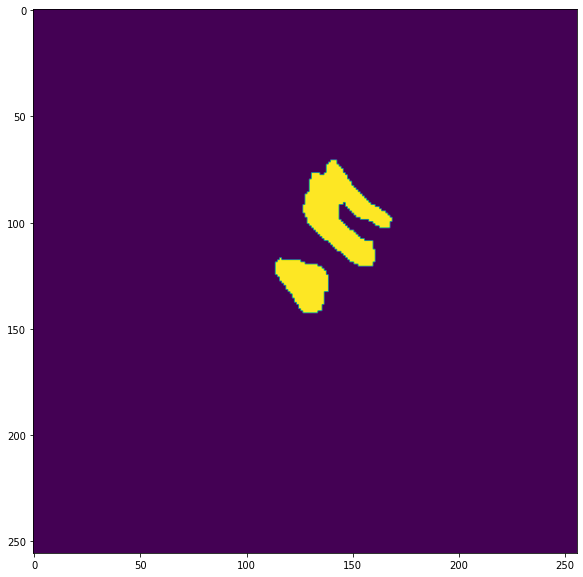

In [98]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize =(10,10))
plt.imshow(example[1][0,:,:,0])
# demo[1].shape

In [91]:
BIAS = np.log(solarPix/nonPix)#np.log(classums[1]/classums[0])
WEIGHT = nonPix/solarPix
WEIGHTS = [1-(nonPix/(solarPix+nonPix)), 1-(solarPix/(solarPix+nonPix))]
TRAIN_SIZE = i#(nonPix+solarPix)/(256*256)#train_con_mat.sum()//(256*256)

print('size = ', TRAIN_SIZE)
print(f'bias = {BIAS}')
print(f'weight = {WEIGHTS}')

size =  11021
bias = -4.272700786590576
weight = [<tf.Tensor: shape=(), dtype=float32, numpy=0.013752341>, <tf.Tensor: shape=(), dtype=float32, numpy=0.98624766>]


In [33]:
BIAS = np.log(solarPix/nonPix)#np.log(classums[1]/classums[0])
WEIGHT = nonPix/solarPix
WEIGHTS = [1-(nonPix/(solarPix+nonPix)), 1-(solarPix/(solarPix+nonPix))]
TRAIN_SIZE = i#(nonPix+solarPix)/(256*256)#train_con_mat.sum()//(256*256)

print('size = ', TRAIN_SIZE)
print(f'bias = {BIAS}')
print(f'weight = {WEIGHTS}')

size =  11021
bias = -4.272700786590576
weight = [<tf.Tensor: shape=(), dtype=float32, numpy=0.013752341>, <tf.Tensor: shape=(), dtype=float32, numpy=0.98624766>]


In [16]:
# use the azure folder as our script folder
source = 'Satellite_ComputerVision'
util_folder = 'utils'
script_folder = f'{source}/azure'
script_file = 'train_solar.py'

In [52]:
custom_env = Environment.from_docker_image(
    name = 'tf_training',
    image = 'mcr.microsoft.com/azureml/openmpi4.1.0-cuda11.2-cudnn8-ubuntu20.04:20221010.v1',
    container_registry=None,
    conda_specification='/mnt/batch/tasks/shared/LS_root/mounts/clusters/mevans1/code/Users/mevans/Solar_UNet/conda_env-copy.yml',
    pip_requirements=None)

In [101]:
# create script run config
# WEIGHT = int(math.ceil(WEIGHT/5)*5)
# define the command line arguments to our training sript
args = [
    '--train_data', train_dataset.as_mount(),
    '--eval_data', eval_dataset.as_mount(),
    '--test_data', test_dataset.as_mount(),
    '--weights', '[0.02, 0.98]',
    '--bias', 0,
    '-lr', 0.001,
    '--epochs', 50,
    '--batch', 16,
    '--size', 11020,
    '--kernel_size', 256,
    '--response', f'{RESPONSE}',
    '--bands', '["B2", "B3", "B4", "B8", "B11", "B12"]',
    '--splits', '[0]']

src = ScriptRunConfig(source_directory='./azure',
                      script='train_solar.py', 
                      arguments=args,
                      compute_target=mevansGPU,
                      environment=custom_env)

In [102]:
#  run the training job
run = exp.submit(config=src, tags = dict({'model':'Unet', 'dataset':'CPK+NC s2', 'normalization':'moment (0,10000)', 'epochs':'0-50'}))
run

Experiment,Id,Type,Status,Details Page,Docs Page
solar-nc-cpk,solar-nc-cpk_1683216093_f764f3c6,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [19]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…